In [1]:
from torch.utils.data import dataset
from tqdm import tqdm
import os
import random
import argparse
import numpy as np
from torch.utils import data
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import normalized_mutual_info_score
import torch
import torch.nn as nn
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s" % device)

Device: cuda


In [2]:
# from src.assp import ASSP_block as ASSP
import torch.nn as nn
from torchvision.models import vgg16_bn
import torch

#Define encoder and decoder components for model definition

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )


class encoder(nn.Module):
    def __init__(self, pretrained=True, inChannel=3):
        super().__init__()

        vgg16 = vgg16_bn(pretrained=pretrained).features
        if(inChannel==4):
            vgg16[0]=nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.block1 = nn.Sequential(vgg16[:6])
        self.block2 = nn.Sequential(vgg16[6:13])
        self.block3 = nn.Sequential(vgg16[13:20])
        self.block4 = nn.Sequential(vgg16[20:27])
        self.block5 = nn.Sequential(vgg16[27:34])
        
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        return [block1, block2, block3, block4, block5]
    
    
class decoder(nn.Module):
    def __init__(self, out_channels=3):
        super().__init__()
        
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x, residuals):  
        
        x = self.up_conv6(x)
        x = torch.cat([x, residuals[4]], dim=1)
        x = self.conv6(x)
        x = self.up_conv7(x)
        x = torch.cat([x, residuals[3]], dim=1)
        x = self.conv7(x)
        x = self.up_conv8(x)
        x = torch.cat([x, residuals[2]], dim=1)
        x = self.conv8(x)
        x = self.up_conv9(x)
        x = torch.cat([x, residuals[1]], dim=1)
        x = self.conv9(x)
        x = self.up_conv10(x)
        x = torch.cat([x, residuals[0]], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)

        return x

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=3):
        super().__init__()
        
        #defining the encoder which is nothing but the encoder of the vgg16 model
        self.encoder = encoder(pretrained=True)
        #defining the bottleneck
        self.bottleneck = nn.Sequential(*vgg16_bn(pretrained=pretrained).features[34:])
        self.conv_bottleneck = conv(512, 1024)
        #defining segmentation decoder
        self.decoder = decoder(out_channels=out_channels)
        #defining reconstruction decoder
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, path=0):
        
        #passing through the encoder
        residuals=self.encoder(x)
        #passing through the bottleneck
        bottleneck = self.bottleneck(residuals[-1])
        x = self.conv_bottleneck(bottleneck)
        
        #height predictions
        preds = self.decoder(x,residuals)
        preds = self.relu(preds)
        return preds      


In [3]:


def readImage(path):
    image = Image.open(path)
    image = np.asarray(image)
    return image

def changeRange(image, newMin, newMax):
    currentMax=np.nanmax(image)
    currentMin=np.nanmin(image)
    return np.interp(image, (currentMin, currentMax), (newMin, newMax))

def saveImage(image, path):
    if(len(image.shape)==2):
        pil_image = Image.fromarray(image)
        pil_image = pil_image.convert('L') 
    else:
        image=image.astype(np.uint8)
        pil_image= Image.fromarray(image)
    pil_image.save(path)

def checkAndLoadData(location):
    print(location)
    image_files = []
    if os.path.isdir(location):
            for ext in ['png', 'jpeg', 'jpg', 'JPEG']:
                files = glob(os.path.join(location, '**/*.%s'%(ext)), recursive=True)
                if len(files)>0:
                    image_files.extend(files)
    elif os.path.isfile(location):
        image_files.append(location)
    return image_files


class seamCarving_dataset(Dataset):
    def __init__(self, rootPath, RGB_transform):
        inputs=os.path.join(rootPath,'Inputs')
        GTs=os.path.join(rootPath,'Ground_Truth')
        self.inputs=checkAndLoadData(inputs)
        self.GTs=checkAndLoadData(GTs)
        self.length=len(self.inputs)
        self.transform=RGB_transform

    def __len__(self):
        return self.length
    
    def getName(self,index):
        name=self.inputs[index]
        index=name.rfind(os.path.sep)
        return name[index+1:]

    def __getitem__(self,index):
        image=readImage(self.inputs[index])
        GT=readImage(self.GTs[index])
        GT = np.stack([np.pad(GT[:,:,0], pad_width=(64,), mode='constant', constant_values=0),
                      np.pad(GT[:,:,1], pad_width=(64,), mode='constant', constant_values=0),
                      np.pad(GT[:,:,2], pad_width=(64,), mode='constant', constant_values=0)],axis=-1)
        if(self.transform!=None):
            image=self.transform(image)
            GT=self.transform(GT)
        # print(image.shape)
        image=image.type(torch.FloatTensor)
        GT=GT.type(torch.FloatTensor)
        return (image, GT)

In [4]:
transform = T.Compose([
                T.ToTensor(),
#                 T.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225]),
            ])
rootPath="/home/scai/msr/aiy227514/scratch/Assignment783/Part2/Dataset"
dataset=seamCarving_dataset(rootPath, transform) 
train_loader=DataLoader(dataset=dataset, batch_size=4,shuffle=True)
dataset.getName(45)

/home/scai/msr/aiy227514/scratch/Assignment783/Part2/Dataset/Inputs
/home/scai/msr/aiy227514/scratch/Assignment783/Part2/Dataset/Ground_Truth


'5783.jpg'

In [5]:
from pytorch_msssim import ssim
import torchvision.models as vggMods
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


class PerceptualLoss(nn.Module):
    def __init__(self, layers=None, weights=None):
        super(PerceptualLoss, self).__init__()
        # Load a pre-trained VGG19 model
        vgg = vggMods.vgg19(pretrained=True).features
        
        # Freeze VGG parameters
        for param in vgg.parameters():
            param.requires_grad = False
        
        # If no specific layers are provided, default to certain layers
        if layers is None:
            layers = {'3': 'relu1_2', '8': 'relu2_2', '17': 'relu3_3', '26': 'relu4_3'}
        
        self.layers = layers
        
        # Extract only the layers of interest
        self.model = nn.Sequential()
        for name, module in vgg._modules.items():
            self.model.add_module(name, module)
            if name in layers:
                break
        self.model=self.model.to(device)
        
        # Define weights for each layer, if not provided default to 1.0
        if weights is None:
            weights = {layer_name: 1.0 for layer_name in layers.values()}
        
        self.weights = weights

    def forward(self, x, y):
        loss = 0.0
        for name, layer in self.model._modules.items():
            x = layer(x)
            y = layer(y)
            
            if name in self.layers:
                layer_loss = nn.functional.mse_loss(x, y)
                loss += self.weights[self.layers[name]] * layer_loss
                loss+= layer_loss
                
        return loss
class SSIM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ssim=ssim

    def forward(self, input, target):
        return self.ssim(input,target, data_range=1, size_average=True)

    
class RMSE(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return torch.sqrt(torch.mean((input - target)**2))

class NMI(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        input=input.view(-1).cpu().detach()
        target=target.view(-1).cpu().detach()
        target=changeRange(target,0,255).astype(np.uint8)
        input=changeRange(input,0,255).astype(np.uint8)
        return normalized_mutual_info_score(target, input)

    
class SSIM_RMSE_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
#         self.mse = torch.nn.MSELoss()
        self.rmse = RMSE()
        self.ssim = SSIM()

    def forward(self, input, target):
        rmse_loss = self.rmse(input, target)
        ssim_loss = 1-ssim(input,target)
        loss = rmse_loss + ssim_loss
        return loss, rmse_loss, ssim_loss
    
    
    
class SSIM_RMSE_NMI_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nmi = NMI()
        self.rmse = RMSE()
        self.ssim = SSIM()

    def forward(self, input, target):
        rmse_loss = self.rmse(input, target)
        ssim_loss = 1-self.ssim(input,target)
        nmi_loss = 1 -self.nmi(input,target)
        loss = rmse_loss + ssim_loss +nmi_loss
        return loss, rmse_loss, ssim_loss, nmi_loss

    
class Perceptual_RMSE_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rmse = RMSE()
        self.percept=PerceptualLoss()
        
    def forward(self, input, target):
        rmse_loss = self.rmse(input, target)
        percept_loss=self.percept(input, target)
        loss = rmse_loss+percept_loss
        return loss, rmse_loss, percept_loss   
        
class Perceptual_L1_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.SmoothL1Loss()
        self.percept=PerceptualLoss(weights={'relu1_2': 0.4, 'relu2_2': 0.3, 'relu3_3': 0.2, 'relu4_3': 0.1})
#         self.percept=PerceptualLoss()
        
    def forward(self, input, target):
        l1_loss = self.l1(input, target)
        percept_loss=self.percept(input, target)
        loss = l1_loss+percept_loss
        return loss, l1_loss, percept_loss  

# lossFunction=torch.nn.MSELoss()
# lossFunction= SSIM_RMSE_Loss()
# lossFunction= SSIM_RMSE_NMI_Loss()
# lossFunction= PerceptualLoss()
# lossFunction= Perceptual_RMSE_Loss()
lossFunction= Perceptual_L1_Loss()
# optimizer=torch.optim.Adam(model.parameters(), lr=0.0001)
model=UNet()
model=model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001,alpha=0.7)
lossArray=[]
model.train()
def train(epoch=50):
    for ep in range(epoch):
        sum=0
#         kl_div_sum=0
        for i, (img,GT) in enumerate(train_loader):
            # print(img.size())
            img=img.to(device)
            GT=GT.to(device)
            out=model(img)
            # print(out.size())
#             loss,_,_,_=lossFunction(GT, out)
#             loss,_,_=lossFunction(GT[:,:,64:-64, 64:-64], out[:,:,64:-64, 64:-64])
            loss,_,_=lossFunction(GT, out)
            sum+=loss.item()
#             kl_div_sum+=kl_div.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             print(loss.item())

        if(ep%50==49):
            torch.save(model.state_dict(), f'Percpt_modell_{ep}')
        print(f'{ep+1} epoch  loss:{sum/len(train_loader)}')
        lossArray.append(sum/len(train_loader))

In [6]:
train(epoch=500)

# #load the dataset
# state_dict = torch.load('/home/scai/msr/aiy227514/scratch/Assignment783/Ass3Part2/pretrained/Adam_Best_Model')
# model.load_state_dict(state_dict)
# train(epoch=100)

1 epoch  loss:0.15137073523490815
2 epoch  loss:0.07614665015323742
3 epoch  loss:0.0718911318611857
4 epoch  loss:0.07118638786109718
5 epoch  loss:0.07023317502761209
6 epoch  loss:0.06918780112991461
7 epoch  loss:0.06918406239836603
8 epoch  loss:0.06882483967756098
9 epoch  loss:0.06820478572233303
10 epoch  loss:0.06840214984038391
11 epoch  loss:0.06750511380566938
12 epoch  loss:0.06746843807097222
13 epoch  loss:0.0674135944478818
14 epoch  loss:0.06699346720769599
15 epoch  loss:0.06721720117068775
16 epoch  loss:0.06692216205536514
17 epoch  loss:0.06663549135162218
18 epoch  loss:0.06694008963736328
19 epoch  loss:0.06674282892128906
20 epoch  loss:0.06642168986837606
21 epoch  loss:0.06607249499978246
22 epoch  loss:0.06618023218234649
23 epoch  loss:0.06591679498150542
24 epoch  loss:0.06579731913233125
25 epoch  loss:0.06571226169330042
26 epoch  loss:0.06548031847420577
27 epoch  loss:0.06542243048347332
28 epoch  loss:0.06526479658645552
29 epoch  loss:0.06542517765853

231 epoch  loss:0.02973289116336083
232 epoch  loss:0.029900993698754826
233 epoch  loss:0.029379663800166267
234 epoch  loss:0.029452063948721498
235 epoch  loss:0.02909988269360887
236 epoch  loss:0.029067954048514366
237 epoch  loss:0.028916941490024328
238 epoch  loss:0.02894843459078992
239 epoch  loss:0.028833636258904997
240 epoch  loss:0.028552038469225972
241 epoch  loss:0.028716929357599567
242 epoch  loss:0.028402106446289533
243 epoch  loss:0.028376257009300833
244 epoch  loss:0.028352083827092034
245 epoch  loss:0.028401071570712973
246 epoch  loss:0.02822157842535022
247 epoch  loss:0.028042645055196574
248 epoch  loss:0.028046290453120664
249 epoch  loss:0.027820427713261264
250 epoch  loss:0.02795115181219739
251 epoch  loss:0.02752369681272555
252 epoch  loss:0.02752350134825384
253 epoch  loss:0.027445990504143206
254 epoch  loss:0.027557271004125878
255 epoch  loss:0.02743896225945571
256 epoch  loss:0.027322398309872764
257 epoch  loss:0.027146400418132544
258 epoch

455 epoch  loss:0.01775674118559707
456 epoch  loss:0.017839154127884557
457 epoch  loss:0.017665338645865385
458 epoch  loss:0.017599604048489315
459 epoch  loss:0.017622137467402058
460 epoch  loss:0.017540509541946893
461 epoch  loss:0.017522042969594132
462 epoch  loss:0.017430529325596383
463 epoch  loss:0.01742459855646499
464 epoch  loss:0.017540367175447377
465 epoch  loss:0.01723277519733922
466 epoch  loss:0.017428430974030414
467 epoch  loss:0.017284218146390206
468 epoch  loss:0.017238994254856498
469 epoch  loss:0.01729777706409427
470 epoch  loss:0.017348240444285644
471 epoch  loss:0.017392476724863454
472 epoch  loss:0.01713495279309919
473 epoch  loss:0.01705536127367334
474 epoch  loss:0.017097347699156083
475 epoch  loss:0.017243676504271256
476 epoch  loss:0.017246844083372806
477 epoch  loss:0.017072425576279294
478 epoch  loss:0.017157692141277162
479 epoch  loss:0.017175541057981348
480 epoch  loss:0.017013202540928852
481 epoch  loss:0.017098227553573007
482 epo

4196.jpg


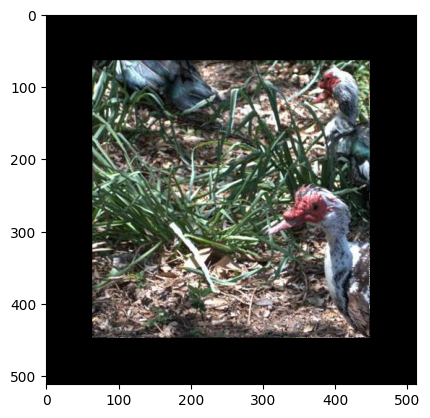

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


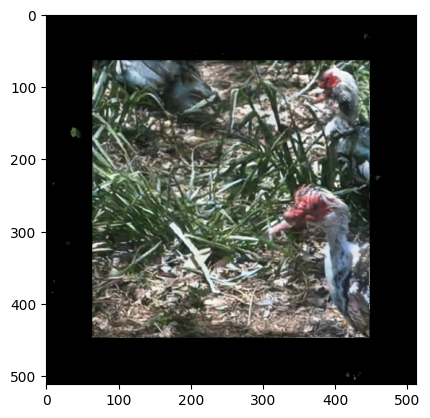

In [12]:
num=41
test=(dataset[num][1]).unsqueeze(0)
print(dataset.getName(num))
# plt.imshow(dataset[num][0])
# plt.show()
plt.imshow(np.transpose(test[0],(1,2,0)))
plt.show()
model.eval()
test=(dataset[num][0]).unsqueeze(0)
test=test.to(device)
out=model(test)
out=out.cpu().detach().numpy()
plt.imshow(np.transpose(out[0],(1,2,0)))
plt.show()

In [8]:
def generateAndSaveOutput(optimizerName):
    output_dir=os.path.join(rootPath,optimizerName)
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    for index in range(len(dataset)):
        img, _=dataset[index]
        name=dataset.getName(index)
        outputPath=os.path.join(output_dir, name)
        img=img.to(device)
        out=model(img.unsqueeze(0))
        out=out[0,:,64:-64,64:-64]
        out=out.cpu().detach().numpy()
    #     saveImage(changeRange(out,0,255),outputPath)
        saveImage(np.transpose(changeRange(out,0,255),(1,2,0)),outputPath)
        print(f'{index+1}/{len(dataset)}')

In [9]:
generateAndSaveOutput('PERCEPT')

1/296
2/296
3/296
4/296
5/296
6/296
7/296
8/296
9/296
10/296
11/296
12/296
13/296
14/296
15/296
16/296
17/296
18/296
19/296
20/296
21/296
22/296
23/296
24/296
25/296
26/296
27/296
28/296
29/296
30/296
31/296
32/296
33/296
34/296
35/296
36/296
37/296
38/296
39/296
40/296
41/296
42/296
43/296
44/296
45/296
46/296
47/296
48/296
49/296
50/296
51/296
52/296
53/296
54/296
55/296
56/296
57/296
58/296
59/296
60/296
61/296
62/296
63/296
64/296
65/296
66/296
67/296
68/296
69/296
70/296
71/296
72/296
73/296
74/296
75/296
76/296
77/296
78/296
79/296
80/296
81/296
82/296
83/296
84/296
85/296
86/296
87/296
88/296
89/296
90/296
91/296
92/296
93/296
94/296
95/296
96/296
97/296
98/296
99/296
100/296
101/296
102/296
103/296
104/296
105/296
106/296
107/296
108/296
109/296
110/296
111/296
112/296
113/296
114/296
115/296
116/296
117/296
118/296
119/296
120/296
121/296
122/296
123/296
124/296
125/296
126/296
127/296
128/296
129/296
130/296
131/296
132/296
133/296
134/296
135/296
136/296
137/296
138/296
139/

In [10]:
# lossFun= SSIM_RMSE_NMI_Loss()
class Matrics(Dataset):
    def __init__(self, rootPath, optimizerName, transform):
        inputs=os.path.join(rootPath,optimizerName)
        GTs=os.path.join(rootPath,'Ground_Truth')
        self.inputs=checkAndLoadData(inputs)
        self.GTs=checkAndLoadData(GTs)
        self.transform=transform
        self.length=len(self.inputs)

    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        image=readImage(self.inputs[index])
        GT=readImage(self.GTs[index])
        if(self.transform!=None):
            image=self.transform(image)
            GT=self.transform(GT)
        image=image.type(torch.FloatTensor)
        GT=GT.type(torch.FloatTensor)
        return (image, GT)
    
# compareDataset=Matrics(rootPath, 'Adam', transform)
compareDataset=Matrics(rootPath, 'PERCEPT', transform)

def compareMatrics():
    MRMS_sum=0
    SSIM_sum=0
    NMI_sum=0
    lossFun=SSIM_RMSE_NMI_Loss()
    for index in range(len(compareDataset)):
#         print(index)
        generated_img, gt = compareDataset[index]
        _,x,y,z=lossFun(generated_img.unsqueeze(0),gt.unsqueeze(0))
        MRMS_sum+=x
        SSIM_sum+=y
        NMI_sum+=z
    return MRMS_sum/len(compareDataset), 1-(SSIM_sum/len(compareDataset)), NMI_sum/len(compareDataset)
compareMatrics()

/home/scai/msr/aiy227514/scratch/Assignment783/Part2/Dataset/PERCEPT
/home/scai/msr/aiy227514/scratch/Assignment783/Part2/Dataset/Ground_Truth


(tensor(0.0681), tensor(0.8186), 0.7055296135118767)